In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime as dt
import math
from sklearn.preprocessing import StandardScaler
import helper
from helper import *

In [11]:
df = load_and_preprocess()
df = df.reset_index(drop = True)

In [12]:
df.shape

(45252, 16)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45252 entries, 0 to 45251
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   datetime        45252 non-null  object 
 1   Description     45252 non-null  object 
 2   Humidity        45252 non-null  float64
 3   Wind Direction  45252 non-null  float64
 4   Temperature     45252 non-null  float64
 5   Pressure        45252 non-null  float64
 6   Wind Speed      45252 non-null  float64
 7   clouds          45252 non-null  int64  
 8   rain            45252 non-null  int64  
 9   mist            45252 non-null  int64  
 10  snow            45252 non-null  int64  
 11  shower          45252 non-null  int64  
 12  thunderstorm    45252 non-null  int64  
 13  fog             45252 non-null  int64  
 14  other           45252 non-null  int64  
 15  Intensity       45252 non-null  float64
dtypes: float64(6), int64(8), object(2)
memory usage: 5.5+ MB


In [5]:
df['datetime']= pd.to_datetime(df['datetime'])

#### Just Using Date/Previous Hour Temp.

In [6]:
df.head()

,datetime,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
0,2012-10-01 13:00:00,heavy clouds,93.0,1001.0,285.830000,230.0,4.0,1,0,0,0,0,0,0,0,3.0
1,2012-10-01 14:00:00,sky is clear,91.0,986.0,285.834650,230.0,4.0,0,0,0,0,0,0,0,0,0.0
2,2012-10-01 15:00:00,sky is clear,87.0,945.0,285.847790,231.0,4.0,0,0,0,0,0,0,0,0,0.0
3,2012-10-01 16:00:00,sky is clear,84.0,904.0,285.860929,233.0,4.0,0,0,0,0,0,0,0,0,0.0
4,2012-10-01 17:00:00,sky is clear,80.0,863.0,285.874069,234.0,3.0,0,0,0,0,0,0,0,0,0.0


In [7]:
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year

#lag features from Duncan
df['lag1'] = df['Temperature'].shift(periods = 1, fill_value = 0)
df['lag2'] = df['Temperature'].shift(periods = 2, fill_value = 0)
df['lag12'] = df['Temperature'].shift(periods = 12, fill_value = 0)
df['lag30'] = df['Temperature'].shift(periods = 30, fill_value = 0)

df['avg_Temperature'] = 0 
for i in range(1, len(df)):
    df['avg_Temperature'][i] = df['lag1'][:i+1].mean()
    

df.drop('Description', axis = 1, inplace = True)
df = df.set_index('datetime')

#we have to eliminate all those with 0s
df = df[df['lag30'] != 0]
df

C:\Users\Steven\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,...,other,Intensity,day,month,year,lag1,lag2,lag12,lag30,avg_Temperature
datetime,,,,,,,,,,,,,,,,,,,,,
2012-10-02 19:00:00,71.861538,1016.424953,288.94,282.0,2.0,0,0,0,0,0,...,0,0.0,2,10,2012,288.94,288.69,286.058023,285.830000,277
2012-10-02 20:00:00,71.861538,1016.424953,288.69,239.0,5.0,0,0,0,0,0,...,0,0.0,2,10,2012,288.94,288.94,286.071162,285.834650,277
2012-10-02 21:00:00,77.000000,1007.000000,288.55,260.0,7.0,1,0,0,0,0,...,0,3.0,2,10,2012,288.69,288.94,286.084302,285.847790,277
2012-10-02 22:00:00,71.861538,1016.424953,288.22,284.0,0.0,0,0,0,0,0,...,0,0.0,2,10,2012,288.55,288.69,286.097442,285.860929,278
2012-10-02 23:00:00,71.861538,1016.424953,287.92,267.0,0.0,0,0,0,0,0,...,0,0.0,2,10,2012,288.22,288.55,286.110581,285.874069,278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-29 20:00:00,64.000000,1021.000000,275.13,300.0,10.0,1,0,0,0,0,...,0,2.0,29,11,2017,276.45,276.15,275.380000,265.120000,280
2017-11-29 21:00:00,59.000000,1023.000000,274.13,300.0,7.0,1,0,0,0,0,...,0,2.0,29,11,2017,275.13,276.45,277.450000,266.120000,280
2017-11-29 22:00:00,66.000000,1024.000000,273.48,290.0,7.0,1,0,0,0,0,...,0,1.0,29,11,2017,274.13,275.13,278.770000,268.100000,280


# Causal Inference

In [8]:
import dowhy
from dowhy import CausalModel

In [9]:
features = df.drop('Temperature', axis=1)
cols = list(features.columns)
cols

['Humidity',
 'Wind Direction',
 'Pressure',
 'Wind Speed',
 'clouds',
 'rain',
 'mist',
 'snow',
 'shower',
 'thunderstorm',
 'fog',
 'other',
 'Intensity',
 'day',
 'month',
 'year',
 'lag1',
 'lag2',
 'lag12',
 'lag30',
 'avg_Temperature']

In [10]:
X = df[cols]
effects = dict()
test = dict()

for i in X:
    model = CausalModel(data = df,
                        treatment = i,
                        outcome = 'Temperature',
                        common_causes = list(X.drop(i, axis = 'columns').columns))
    
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.linear_regression",
                                    test_significance = True)
    
    effects[i] = estimate.value
    test[i] = estimate

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Humidity'] on outcome ['Temperature']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: Temperature~Humidity+Wind Speed+lag2+shower+lag1+lag30+fog+thunderstorm+day+other+lag12+rain+month+Pressure+snow+clouds+Intensity+Wind Direction+avg_Temperature+mist+year
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node

## Final Output Preprocessing

In [11]:
#piecing together the dataframes and also processing out the p-values (brute force)
estimates = pd.DataFrame(effects.items(),columns=['Feature', 'Estimate'])
tests = pd.DataFrame(test.items(), columns=['Feature', 'P-Values'])
tests = tests.astype(str)
tests['P-Values'] = tests['P-Values'].str.split('p-value: ').str[-1]
tests['P-Values'] = tests['P-Values'].str.replace(r'[', '')
tests['P-Values'] = tests['P-Values'].str.replace(r']\n', '')
tests = tests.astype({"P-Values": float})
tests['Estimate'] = estimates['Estimate']
finaldf = tests.round(3).sort_values('Estimate')

C:\Users\Steven\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
C:\Users\Steven\anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  import sys


In [12]:
finaldf 

,Feature,P-Values,Estimate
9,thunderstorm,0.000,-0.510
17,lag2,0.000,-0.262
8,shower,0.046,-0.062
19,lag30,0.000,-0.031
3,Wind Speed,0.005,-0.007
0,Humidity,0.000,-0.003
2,Pressure,0.000,-0.001
13,day,0.883,0.000
1,Wind Direction,0.038,0.001
20,avg_Temperature,0.601,0.002


In [13]:
#features with high causal inference
high_evd = finaldf[finaldf['P-Values'] <= 0.05]
high_evd

,Feature,P-Values,Estimate
9,thunderstorm,0.000,-0.510
17,lag2,0.000,-0.262
8,shower,0.046,-0.062
19,lag30,0.000,-0.031
3,Wind Speed,0.005,-0.007
0,Humidity,0.000,-0.003
2,Pressure,0.000,-0.001
1,Wind Direction,0.038,0.001
14,month,0.000,0.008
18,lag12,0.000,0.035


In [14]:
#features with low causal inference
low_evd = finaldf[finaldf['P-Values'] >= 0.05]
low_evd

,Feature,P-Values,Estimate
13,day,0.883,0.000
20,avg_Temperature,0.601,0.002
15,year,0.500,0.003
12,Intensity,0.268,0.010
10,fog,0.664,0.026
11,other,0.641,0.119


In [28]:
#reference for a helper function

def causal_inf_output(): 
    estimates = pd.DataFrame(effects.items(),columns=['Feature', 'Estimate'])
    tests = pd.DataFrame(test.items(), columns=['Feature', 'P-Values'])
    tests = tests.astype(str)
    tests['P-Values'] = tests['P-Values'].str.split('p-value: ').str[-1]
    tests['P-Values'] = tests['P-Values'].str.replace(r'[', '')
    tests['P-Values'] = tests['P-Values'].str.replace(r']\n', '')
    tests = tests.astype({"P-Values": float})
    tests['Estimate'] = estimates['Estimate']
    finaldf = tests.round(3).sort_values('Estimate')
    return finaldf

# Causal Inference Version 2

In [39]:
df = load_and_preprocess()
df = df.reset_index(drop = True)
df['Temperature'] = df['Temperature'] -273.15
df

,datetime,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity
0,2012-10-01 13:00:00,heavy clouds,93.00,1001.00,12.68,230.00,4.00,1,0,0,0,0,0,0,0,3.00
1,2012-10-01 14:00:00,sky is clear,91.00,986.00,12.68,230.00,4.00,0,0,0,0,0,0,0,0,0.00
2,2012-10-01 15:00:00,sky is clear,87.00,945.00,12.70,231.00,4.00,0,0,0,0,0,0,0,0,0.00
3,2012-10-01 16:00:00,sky is clear,84.00,904.00,12.71,233.00,4.00,0,0,0,0,0,0,0,0,0.00
4,2012-10-01 17:00:00,sky is clear,80.00,863.00,12.72,234.00,3.00,0,0,0,0,0,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45247,2017-11-29 20:00:00,moderate clouds,64.00,1021.00,1.98,300.00,10.00,1,0,0,0,0,0,0,0,2.00
45248,2017-11-29 21:00:00,moderate clouds,59.00,1023.00,0.98,300.00,7.00,1,0,0,0,0,0,0,0,2.00
45249,2017-11-29 22:00:00,light clouds,66.00,1024.00,0.33,290.00,7.00,1,0,0,0,0,0,0,0,1.00
45250,2017-11-29 23:00:00,light clouds,58.00,1026.00,-0.67,290.00,4.00,1,0,0,0,0,0,0,0,1.00


3.00     7808
2.00     7307
4.00     6594
1.00     6310
5.00     5127
6.00     4118
7.00     2477
0.00     1726
8.00     1681
9.00      936
10.00     526
11.00     304
12.00     143
13.00      93
14.00      44
15.00      21
17.00      18
19.00       5
16.00       4
18.00       4
20.00       3
21.00       2
24.00       1
Name: Wind Speed, dtype: int64


<AxesSubplot:>

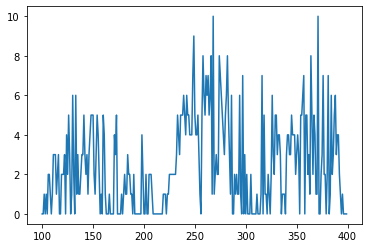

In [40]:
print(df['Wind Speed'].value_counts())
df['Wind Speed'][100:400].plot()

In [41]:
df['datetime']= pd.to_datetime(df['datetime'])
df['season'] = (df['datetime'].dt.month%12 + 3)//3

seasons = {
             1: 'Winter',
             2: 'Spring',
             3: 'Summer',
             4: 'Autumn'
}

df['season_name'] = df['season'].map(seasons)
df

,datetime,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity,season,season_name
0,2012-10-01 13:00:00,heavy clouds,93.00,1001.00,12.68,230.00,4.00,1,0,0,0,0,0,0,0,3.00,4,Autumn
1,2012-10-01 14:00:00,sky is clear,91.00,986.00,12.68,230.00,4.00,0,0,0,0,0,0,0,0,0.00,4,Autumn
2,2012-10-01 15:00:00,sky is clear,87.00,945.00,12.70,231.00,4.00,0,0,0,0,0,0,0,0,0.00,4,Autumn
3,2012-10-01 16:00:00,sky is clear,84.00,904.00,12.71,233.00,4.00,0,0,0,0,0,0,0,0,0.00,4,Autumn
4,2012-10-01 17:00:00,sky is clear,80.00,863.00,12.72,234.00,3.00,0,0,0,0,0,0,0,0,0.00,4,Autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45247,2017-11-29 20:00:00,moderate clouds,64.00,1021.00,1.98,300.00,10.00,1,0,0,0,0,0,0,0,2.00,4,Autumn
45248,2017-11-29 21:00:00,moderate clouds,59.00,1023.00,0.98,300.00,7.00,1,0,0,0,0,0,0,0,2.00,4,Autumn
45249,2017-11-29 22:00:00,light clouds,66.00,1024.00,0.33,290.00,7.00,1,0,0,0,0,0,0,0,1.00,4,Autumn
45250,2017-11-29 23:00:00,light clouds,58.00,1026.00,-0.67,290.00,4.00,1,0,0,0,0,0,0,0,1.00,4,Autumn


In [42]:
#a function that turns continuous variables into categories, for easier interpreation in causal inference
def cont_into_cat(column):
    labels = ['low', 'medium', 'high']
    df[column+' Quantiles'] = pd.qcut(df[column],
                                              q=3,
                                              labels=labels,
                                              precision=0)

df.sample(5)

,datetime,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,snow,shower,thunderstorm,fog,other,Intensity,season,season_name
24491,2015-07-19 00:00:00,moderate clouds,69.00,1009.00,24.10,290.00,2.00,1,0,0,0,0,0,0,0,2.00,3,Summer
33163,2016-07-14 08:00:00,light clouds,78.00,1015.00,23.81,220.00,4.00,1,0,0,0,0,0,0,0,1.00,3,Summer
44294,2017-10-21 03:00:00,sky is clear,62.00,1020.00,11.63,250.00,4.00,0,0,0,0,0,0,0,0,0.00,4,Autumn
44364,2017-10-24 01:00:00,moderate clouds,72.00,1016.00,17.98,160.00,6.00,1,0,0,0,0,0,0,0,2.00,4,Autumn
31093,2016-04-19 02:00:00,mist,93.00,1022.00,4.82,30.00,4.00,0,0,1,0,0,0,0,0,2.00,2,Spring


In [43]:
#test = ['Humidity Quantiles','Wind Speed Quantiles','Pressure Quantiles']
#df.drop(test, axis = 1, inplace = True)
#df.sample(5)

In [44]:
cont_into_cat('Wind Speed')
cont_into_cat('Humidity')
cont_into_cat('Pressure')

df.sample(5)

,datetime,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,...,shower,thunderstorm,fog,other,Intensity,season,season_name,Wind Speed Quantiles,Humidity Quantiles,Pressure Quantiles
2320,2013-01-06 05:00:00,heavy snow,86.00,1005.00,-1.16,240.00,12.00,0,0,0,...,0,0,0,0,3.00,1,Winter,high,high,medium
33916,2016-08-14 17:00:00,light rain,84.00,1004.00,18.62,255.00,6.00,0,1,0,...,0,0,0,0,1.00,3,Summer,high,high,high
10153,2013-11-28 14:00:00,moderate clouds,72.00,1017.00,-8.52,250.00,8.00,1,0,0,...,0,0,0,0,2.00,4,Autumn,high,medium,medium
15285,2014-06-30 10:00:00,heavy clouds,73.00,1013.00,22.31,160.00,4.00,1,0,0,...,0,0,0,0,3.00,3,Summer,medium,medium,medium
15693,2014-07-17 10:00:00,light clouds,87.00,1013.00,14.15,240.00,3.00,1,0,0,...,0,0,0,0,1.00,3,Summer,medium,high,medium


In [45]:
#dummify new categorical variables
import pandas as pd
import numpy as np
df = pd.get_dummies(df, columns = ['Wind Speed Quantiles'])
df = pd.get_dummies(df, columns = ['Humidity Quantiles'])
df = pd.get_dummies(df, columns = ['Pressure Quantiles'])
df = pd.get_dummies(df, columns = ['season_name'])

df.sample(5)

,datetime,Description,Humidity,Wind Direction,Temperature,Pressure,Wind Speed,clouds,rain,mist,...,Humidity Quantiles_low,Humidity Quantiles_medium,Humidity Quantiles_high,Pressure Quantiles_low,Pressure Quantiles_medium,Pressure Quantiles_high,season_name_Autumn,season_name_Spring,season_name_Summer,season_name_Winter
32456,2016-06-14 21:00:00,moderate clouds,38.00,1009.00,20.70,0.00,1.00,1,0,0,...,1,0,0,1,0,0,0,0,1,0
27413,2015-11-17 18:00:00,moderate clouds,51.00,1035.00,3.45,19.00,2.00,1,0,0,...,1,0,0,1,0,0,1,0,0,0
148,2012-10-07 17:00:00,moderate clouds,71.86,1016.42,10.36,240.00,5.00,1,0,0,...,0,1,0,0,1,0,1,0,0,0
29780,2016-02-24 09:00:00,light snow,92.00,1024.00,-5.31,30.00,3.00,0,0,0,...,0,0,1,1,0,0,0,0,0,1
15914,2014-07-26 15:00:00,moderate clouds,68.00,1011.00,22.65,210.00,6.00,1,0,0,...,0,1,0,0,1,0,0,0,1,0


In [46]:
#cols_drop = ['Temperature', 'Description', 'datetime', 'Humidity', 'Wind Direction','Pressure','Wind Speed','Intensity',]
cols_drop = ['Temperature', 'Description', 'datetime', 'Wind Direction','Intensity','Wind Speed Quantiles_medium',
             'Humidity Quantiles_medium','Pressure Quantiles_medium', 'season','other','shower']

features = df.drop(cols_drop, axis=1)
cols = list(features.columns)
cols

['Humidity',
 'Pressure',
 'Wind Speed',
 'clouds',
 'rain',
 'mist',
 'snow',
 'thunderstorm',
 'fog',
 'Wind Speed Quantiles_low',
 'Wind Speed Quantiles_high',
 'Humidity Quantiles_low',
 'Humidity Quantiles_high',
 'Pressure Quantiles_low',
 'Pressure Quantiles_high',
 'season_name_Autumn',
 'season_name_Spring',
 'season_name_Summer',
 'season_name_Winter']

In [47]:
import dowhy
from dowhy import CausalModel

X = df[cols]
effects = dict()
test = dict()

for i in X:
    model = CausalModel(data = df,
                        treatment = i,
                        outcome = 'Temperature',
                        common_causes = list(X.drop(i, axis = 'columns').columns))
    
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.linear_regression",
                                    test_significance = True)
    
    effects[i] = estimate.value
    test[i] = estimate

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Humidity'] on outcome ['Temperature']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: Temperature~Humidity+Wind Speed+rain+season_name_Winter+Humidity Quantiles_high+Wind Speed Quantiles_low+Pressure Quantiles_high+season_name_Spring+season_name_Summer+fog+mist+Pressure+season_name_Autumn+clouds+Pressure Quantiles_low+snow+Wind Speed Quantiles_high+Humidity Quantiles_low+thunderstorm
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: Temperature~snow+Wind Speed+rain+season_name_Winter+Humidity Quantiles_high+Wind Speed Quantiles_low+Pressure Quantiles_high+season_name_Spring+season_name_Summer+fog+mist+Pressure+season_name_Autumn+clouds+Pressure Quantiles_low+Humidity+Wind Speed Quantiles_high+Humidity Quantiles_low+thunderstorm
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['thunderstorm'] on outcome ['Temperature']
INFO:do

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Pressure Quantiles_low'] on outcome ['Temperature']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: Temperature~Pressure Quantiles_low+Wind Speed+rain+season_name_Winter+Humidity Quantiles_high+Wind Speed Quantiles_low+Pressure Quantiles_high+season_name_Spring+season_name_Summer+fog+mist+Pressure+season_name_Autumn+clouds+Humidity+snow+Wind Speed Quantiles_high+Humidity Quantiles_low+thundersto

In [48]:
pd.options.display.float_format = '{:.2f}'.format
#pd.reset_option('^display.', silent=True)
causal_inf_output()

C:\Users\Steven\anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  
C:\Users\Steven\anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


,Feature,P-Values,Estimate
18,season_name_Winter,0.00,-10.23
14,Pressure Quantiles_high,0.00,-4.08
6,snow,0.00,-1.55
11,Humidity Quantiles_low,0.00,-0.97
13,Pressure Quantiles_low,0.00,-0.78
9,Wind Speed Quantiles_low,0.00,-0.69
10,Wind Speed Quantiles_high,0.00,-0.57
0,Humidity,0.00,-0.11
1,Pressure,0.00,0.01
2,Wind Speed,0.00,0.20
